In [1]:
from skimage.feature import graycomatrix, graycoprops

# Hitung fitur GLCM
def compute_glcm(image, angles):
    glcm = graycomatrix(image, distances=[1], angles=angles, levels=256, symmetric=True, normed=True)
    return glcm

In [2]:
import numpy as np

# Hitung matriks GLCM
def glcm_matrix(image):
    matrix = []
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
    metric_texture = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
    for i in metric_texture:
        row = []
        for j in angles:
            row.append(graycoprops(compute_glcm(image, [j]), prop=i)[0][0])
        matrix.append(row)
    return np.array(matrix).flatten()

In [3]:
X = []  # Features
y = []  # Labels

In [4]:
import os
from skimage import io, color, util

# Load citra dengan ekspresi happy
positive_images = os.listdir("dataset/happy/")
for img_path in positive_images:
    image = io.imread("dataset/happy/" + img_path)
    features = glcm_matrix(image)
    X.append(features)
    y.append(1)  # Sentimen positif

In [5]:
# Load citra dengan ekspresi sad
negative_images = os.listdir("dataset/sad/")
for img_path in negative_images:
    image = io.imread("dataset/sad/" + img_path)
    features = glcm_matrix(image)
    X.append(features)
    y.append(0)  # Sentimen negatif

In [6]:
from sklearn.model_selection import train_test_split

# Pisahkan data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

# Melatih klasifikasi KNN dengan nilai k dan metrik jarak yang berbeda
k_values = list(range(1, 100, 2))  # Percobaan nilai k
distance_metrics = ['euclidean', 'manhattan', 'cosine']  # Percobaan rumus jarak

results = []
accuracy_data = []

for distance_metric in distance_metrics:
    row = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=distance_metric).fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accuracy = knn.score(X_test, y_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        row.append(accuracy)

        results.append({
            'k': k,
            'distance_metric': distance_metric,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })

    accuracy_data.append(row)

num_results = len(results)
middle_index = num_results // 2
middle_result = results[middle_index]

best_index = max(range(len(results)), key=lambda i: results[i]['accuracy'])
best_result = results[best_index]

worst_index = min(range(len(results)), key=lambda i: results[i]['accuracy'])
worst_result = results[worst_index]

print("The Best:")
print(f"k: {best_result['k']}")
print(f"Distance Metric: {best_result['distance_metric']}")
print(f"Accuracy: {round(best_result['accuracy'] * 100)}%")
print(f"Precision: {round(best_result['precision'], 2)}")
print(f"Recall: {round(best_result['recall'], 2)}")
print(f"F1-Score: {round(best_result['f1_score'], 2)}")
print()

print("The Middle:")
print(f"k: {middle_result['k']}")
print(f"Distance Metric: {middle_result['distance_metric']}")
print(f"Accuracy: {round(middle_result['accuracy'] * 100)}%")
print(f"Precision: {round(middle_result['precision'], 2)}")
print(f"Recall: {round(middle_result['recall'], 2)}")
print(f"F1-Score: {round(middle_result['f1_score'], 2)}")
print()

print("The Worst:")
print(f"k: {worst_result['k']}")
print(f"Distance Metric: {worst_result['distance_metric']}")
print(f"Accuracy: {round(worst_result['accuracy'] * 100)}%")
print(f"Precision: {round(worst_result['precision'], 2)}")
print(f"Recall: {round(worst_result['recall'], 2)}")
print(f"F1-Score: {round(worst_result['f1_score'], 2)}")

The Best:
k: 77
Distance Metric: euclidean
Accuracy: 58%
Precision: 0.59
Recall: 0.74
F1-Score: 0.66

The Middle:
k: 51
Distance Metric: manhattan
Accuracy: 55%
Precision: 0.56
Recall: 0.69
F1-Score: 0.62

The Worst:
k: 1
Distance Metric: euclidean
Accuracy: 49%
Precision: 0.52
Recall: 0.5
F1-Score: 0.51


In [8]:
# Menyimpan model
df = pd.DataFrame(accuracy_data, columns=k_values, index=distance_metrics)
df.to_csv('models.csv', index=False)

best_model = KNeighborsClassifier(n_neighbors=best_k, metric=best_distance_metric).fit(X_train, y_train)
joblib.dump(best_model, "best_model")

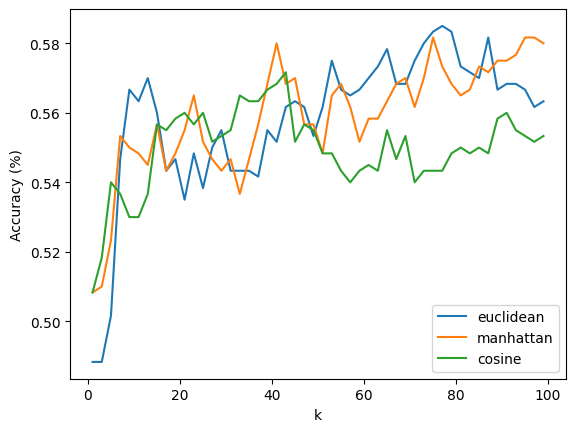

In [9]:
import matplotlib.pyplot as plt

for i, distance_metric in enumerate(distance_metrics):
    plt.plot(k_values, accuracy_data[i], label=distance_metric)

plt.xlabel('k')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()